In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

In [2]:
from astropy.table import Table
from astropy.time import Time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize'] = [15, 15]
size=18
params = {'legend.fontsize': size,
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

In [3]:
from jetset.model_parameters import ModelParameterArray, ModelParameter
from jetset.analytical_model import AnalyticalParameter
from jetset.base_model import Model
from jetset.model_manager import FitModel
from jetset.minimizer import fit_SED

In [4]:
class GrowthModel(Model):
    """
    Class to handle function for growth model
    """
    
    def __init__(self,nu_size=100,**keywords):
        """
        """
     
        super(GrowthModel,self).__init__(  **keywords)
        self.name='GrowthModel'
        self.parameters = ModelParameterArray()      
        self.eta=1
        self.parameters.add_par(AnalyticalParameter(self,name='eta',par_type='',val=1,val_min=0,val_max=10000,units=''))        
        self.R0=1
        self.parameters.add_par(AnalyticalParameter(self,name='R0',par_type='',val=3,val_min=0.,val_max=10.,units=''))       
        self.tau=1
        self.parameters.add_par(AnalyticalParameter(self,name='tau',par_type='',val=1,val_min=0.,val_max=10.,units=''))
        self.t_0=1
        self.parameters.add_par(AnalyticalParameter(self,name='t_0',par_type='',val=0,val_min=-10.,val_max=100.,units=''))
    
    def set(self,**keywords):
        super(GrowthMode,self).set(**keywords )

        """
        sets a parameter value checking for physical boundaries 
        """
        if 'val' in keywords.keys():
            self.assign_val(self.name,keywords['val']) 

    def assign_val(self,name,val):
        setattr(self.polymodel,name,val)
    
    #def lin_func(self,nu):        
    #    return -np.log10(self.eta) +(np.log10(self.R0)/self.tau)*(nu-self.eta)
    
    def lin_func(self,nu):
        return (1.0/self.eta)*np.power(self.R0,((nu-self.t_0)/self.tau))
    

In [5]:
class Data(object):
    
    def __init__(self,data,time):
        self.data=data
        self.time=time.date

In [6]:
def get_data(name='Confirmed'):
    """
    name= Confirmed, Deaths, Recovered
    """
    table=Table.read('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-%s.csv'%name)
    ts=table[table['Country/Region']=='Italy']
    df=ts.to_pandas()
    y=df.values
    y=y.flatten()[4:].astype(np.int)
    t=df.columns[4:]
    msk=y>-1
    
    time=np.arange(1,len(t)+1)
    msk=time>20
    t=t[msk]
    data_table=Table([time[msk], y[msk], np.sqrt(y[msk]), np.zeros(len(y[msk]),dtype=np.bool )],names=['nu_data','nuFnu_data','dnuFnu_data','UL'])
    data=Data(data_table,pd.to_datetime(t,format='%m/%d/%y'))
    return data

In [18]:
def plot_model(mcmc,model,data, nu_1, nu_2, size=10, labels=None,label=''):
    
    nu=np.linspace(nu_1,nu_2,100)

    mcmc.reset_to_best_fit()
    p=np.log10(model.GrowthModel.parameters.R0.best_fit_val)/model.GrowthModel.parameters.tau.val
    y = np.zeros((size,nu.size))

    for ID,ID_rand in enumerate(np.random.randint(len(mcmc.samples), size=size)):
        for ID_par,pi in  enumerate(mcmc.par_array):
            pi.set(val = mcmc.get_par(ID_par)[0][ID_rand])
  
        y[ID] = model.eval(nu,get_model=True)
    
    #print(ID)
    y_min=np.amin(y, axis=0)
    y_max=np.amax(y, axis=0)
    plt.fill_between(nu,y_max,y_min,color='gray',alpha=0.3)
    
    mcmc.reset_to_best_fit()
    y_bf=model.eval(nu,get_model=True)
    
    plt.plot(nu,y_bf,label= label+': Predicted, log10(R0)/tau=%3.3f'%p)
    
    plt.errorbar(data.data['nu_data'],data.data['nuFnu_data'],yerr=data.data['dnuFnu_data'],fmt='o',label = label+': Observed')
    
    plt.axvline(model.nu_min_fit,alpha=0.5)
    plt.axvline(model.nu_max_fit,alpha=0.5)
    
    
    locs, labels = plt.xticks()
    delta_t=data.time +pd.Timedelta(days=30)
    t=np.append(data.time,delta_t)
    delta_x=np.arange(1,31)+data.data['nu_data'][-1]
    x=np.append(data.data['nu_data'],delta_x)
    plt.xticks(x, t, rotation='vertical') 
    plt.xlabel('date')
    plt.ylabel('Counts')
    plt.semilogy()
    plt.legend()
    mcmc.reset_to_best_fit()
    #plt.suptitle('data from https://github.com/CSSEGISandData/COVID-19')

In [8]:
from jetset.minimizer import fit_SED
from jetset.mcmc import McmcSampler


In [15]:
name='Deaths'
data=get_data(name)
gm_d=GrowthModel()
gm_d.nu_min=0
gm_d.nu_max=100
fm_d=FitModel(analytical=gm_d,name='test')
bfm_d,mm_d=fit_SED(fm_d,data,nu_fit_start=35,nu_fit_stop=50,minimizer='minuit',silent=True)
print(np.log10(gm_d.parameters.R0.val)/gm_d.parameters.tau.val)
bfm_d.fit_Model.show_best_fit_pars()

mcmc_d=McmcSampler(bfm_d.fit_Model,bfm_d.data)
mcmc_d.run_sampler(nwalkers=150,burnin=10,steps=500,bound=3,bound_rel=True,walker_start_bound=0.001,threads=1)

  1%|          | 5/500 [00:00<00:10, 49.27it/s]

0.13357333298596744
 model name name bestfit val     err +     err -  start val   fit range min fit range max frozen
----------- ---- ------------ ------------ ----- ------------ ------------- ------------- ------
GrowthModel  eta 1.138581e+01 1.975976e+01    -- 1.000000e+00  0.000000e+00  1.000000e+04  False
GrowthModel   R0 1.599732e+00 7.232400e-01    -- 3.000000e+00  0.000000e+00  1.000000e+01  False
GrowthModel  tau 1.527605e+00 1.426799e+00    -- 1.000000e+00  0.000000e+00  1.000000e+01  False
GrowthModel  t_0 2.007000e+01 5.668961e+00    -- 0.000000e+00 -1.000000e+01  1.000000e+02  False
mcmc run starting


100%|██████████| 500/500 [00:09<00:00, 54.13it/s]

mcmc run done, with 1 threads took 9.26 seconds


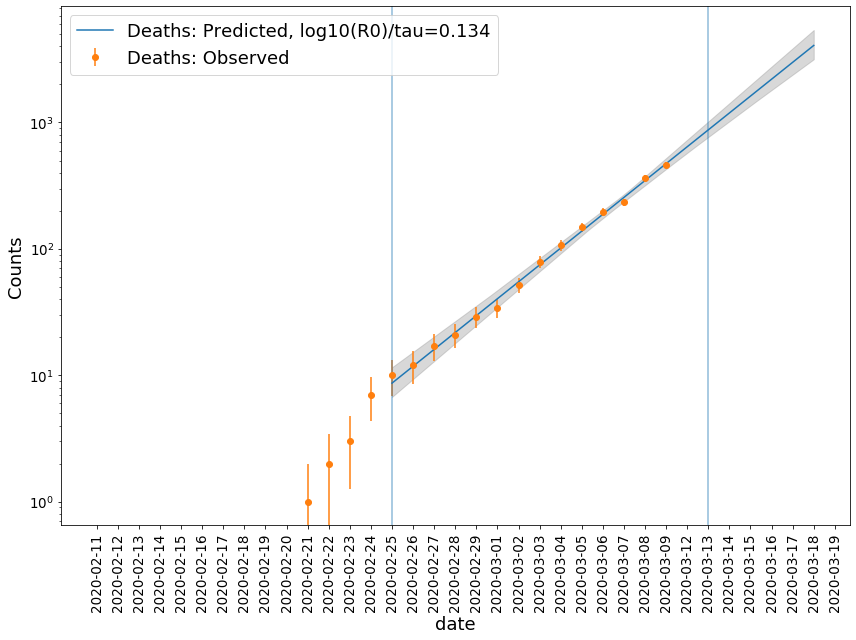

In [19]:
%matplotlib inline
fig=plt.figure(figsize=(12,9))
plot_model(mcmc_d,bfm_d.fit_Model,data,35,55,label=name,size=500)
plt.tight_layout()

<Figure size 864x576 with 0 Axes>

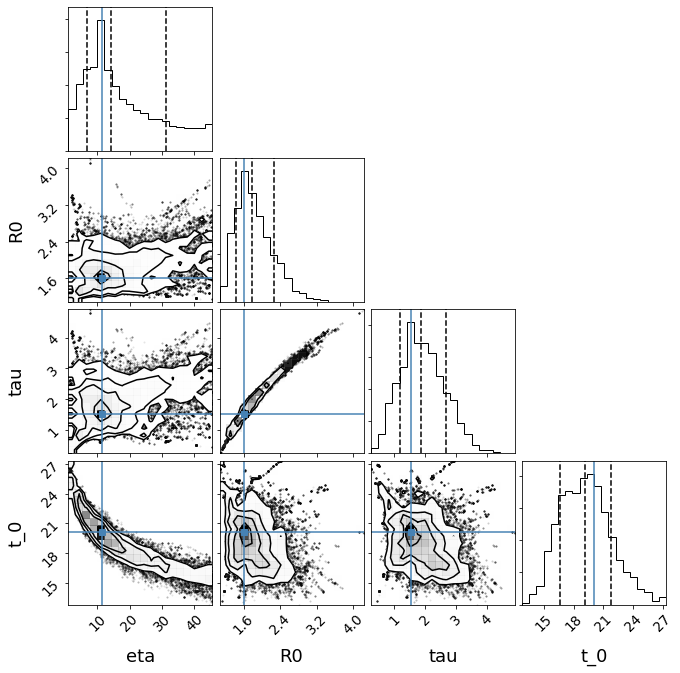

In [20]:
fig=plt.figure(figsize=(12,8))
f=mcmc_d.corner_plot()

In [23]:
name='Confirmed'
data=get_data(name)
gm_c=GrowthModel()
gm_c.nu_min=0
gm_c.nu_max=100
fm_c=FitModel(analytical=gm_c,name='test')
bfm_c,mm_c=fit_SED(fm_c,data,nu_fit_start=35,nu_fit_stop=50,minimizer='minuit',silent=True)
print(np.log10(gm_c.parameters.R0.val)/gm_c.parameters.tau.val)

bfm_c.fit_Model.show_best_fit_pars()

mcmc_c=McmcSampler(bfm_c.fit_Model,bfm_c.data)
mcmc_c.run_sampler(nwalkers=150,burnin=10,steps=500,bound=3,bound_rel=True,walker_start_bound=0.001,threads=1)

  1%|          | 5/500 [00:00<00:10, 48.11it/s]

0.13544716160657988
 model name name bestfit val     err +     err -  start val   fit range min fit range max frozen
----------- ---- ------------ ------------ ----- ------------ ------------- ------------- ------
GrowthModel  eta 4.227074e+00 6.061790e+03    -- 1.000000e+00  0.000000e+00  1.000000e+04  False
GrowthModel   R0 1.602817e+00 5.762701e+00    -- 3.000000e+00  0.000000e+00  1.000000e+01  False
GrowthModel  tau 1.512649e+00 5.705960e+00    -- 1.000000e+00  0.000000e+00  1.000000e+01  False
GrowthModel  t_0 1.389181e+01 6.693322e+01    -- 0.000000e+00 -1.000000e+01  1.000000e+02  False
mcmc run starting


100%|██████████| 500/500 [00:09<00:00, 51.37it/s]

mcmc run done, with 1 threads took 9.76 seconds


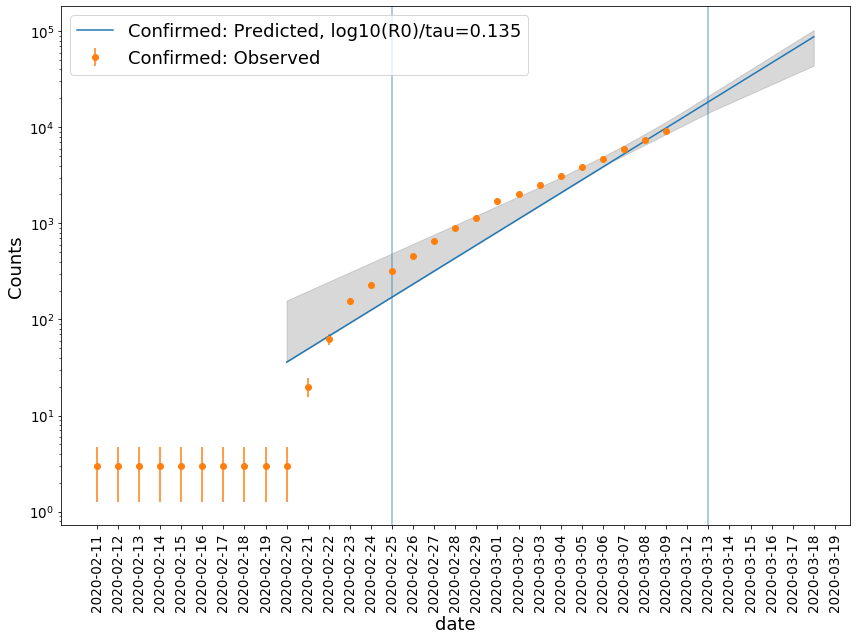

In [24]:
%matplotlib inline
fig=plt.figure(figsize=(12,9))
plot_model(mcmc_c,bfm_c.fit_Model,data,30,55,label=name,size=500)
plt.tight_layout()

<Figure size 864x576 with 0 Axes>

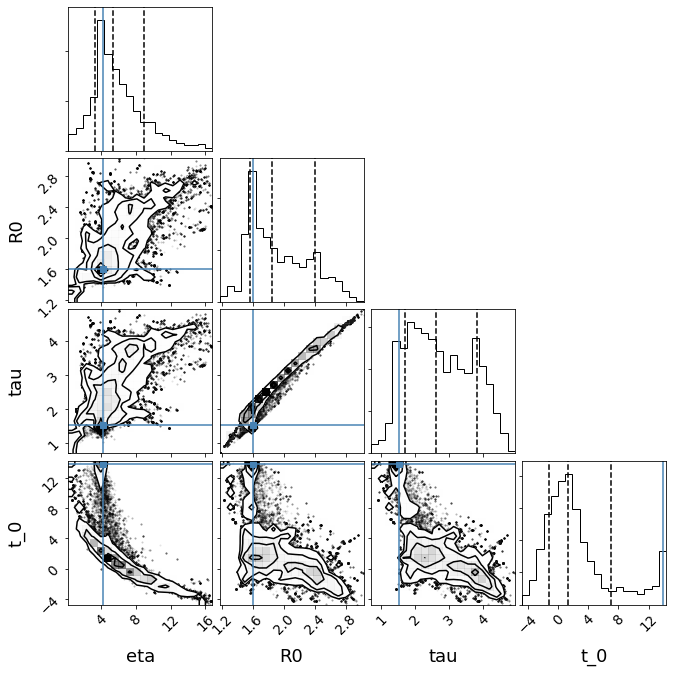

In [25]:
fig=plt.figure(figsize=(12,8))
f=mcmc_c.corner_plot()